# Model Train and validation

In [2]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense, Dropout

/opt/anaconda3/envs/tensorlow/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/anaconda3/envs/tensorlow/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue

## Hyperparameter

In [3]:
EPOCHS = 1000
RESULT_SAVE_PATH = '/Users/shim/dl-python-ImageDetection/dataset/results/'
TFRECORD_PATH = '/Users/shim/dl-python-ImageDetection/dataset/tfrecords/'


## Define the model Inception-based

In [5]:
def Model():
    def inception(filters):
        def subnetwork(x):
            # padding=same to enable concatenation with other filters
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

## Define the Data Preprocessing Functions 

In [6]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

In [7]:
def get_files_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

## Define the Data Augmentation Function

In [8]:
def augmentation(img, label):
    def flip(x):
        x= tf.image.random_flip_left_right(x)
        x= tf.image.random_flip_up_down(x)
        return x
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0,dtype=tf.float32)>0.5,
                   lambda: tfa.image.rotate(x, tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                                                interpolation='BILINEAR'),
                   lambda: x)
        return x
                    
    def translation(x):
        dx= tf.random.uniform(shape=[], minval=-10.0, maxval=10.0,dtype=tf.float32)
        dy= tf.random.uniform(shape=[], minval=-10.0, maxval=10.0,dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) >0.5,
                   lambda: tfa.image.transform(x, [0,0,dx, 0,0,dy, 0,0], #At the end, 20 is a scale factor
                                              interpolation='BILINEAR'),
                   lambda: x)
        return x
    img = flip(img)
    img = rotate(img)
    img = translation(img)    
            
    return img, label

## Import TFRecords 

In [9]:
tffiles = get_files_list(TFRECORD_PATH)
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

2023-10-27 11:33:32.480478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Splite train, validation set

In [10]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

In [12]:
train_size

1736

In [177]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_size = int(ds_size * train_ratio)
validation_size = int(ds_size * validation_ratio)
test_size = int(ds_size * test_ratio)
ds = dataset.shuffle(ds_size, reshuffle_each_iteration=False)

ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).take(validation_size).prefetch(1024).batch(32)
ds_test = ds.skip(train_size + validation_size).prefetch(1024).batch(32)


## Build the Model

In [13]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [14]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
55/55 [==============================] - 145s 3s/step - loss: 0.7042 - accuracy: 0.5196 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/1000
55/55 [==============================] - 154s 3s/step - loss: 0.6848 - accuracy: 0.5513 - val_loss: 0.6822 - val_accuracy: 0.5040
Epoch 3/1000
55/55 [==============================] - 166s 3s/step - loss: 0.6622 - accuracy: 0.5997 - val_loss: 0.8991 - val_accuracy: 0.4718
Epoch 4/1000
55/55 [==============================] - 167s 3s/step - loss: 0.7027 - accuracy: 0.5046 - val_loss: 0.6919 - val_accuracy: 0.5134
Epoch 5/1000
55/55 [==============================] - 161s 3s/step - loss: 0.6935 - accuracy: 0.5017 - val_loss: 0.6892 - val_accuracy: 0.5094
Epoch 6/1000
55/55 [==============================] - 168s 3s/step - loss: 0.6894 - accuracy: 0.5467 - val_loss: 0.6855 - val_accuracy: 0.4960
Epoch 7/1000
55/55 [==============================] - 175s 3s/step - loss: 0.6935 - accuracy: 0.4775 - val_loss: 0.6928 - val_accuracy: 0.6519

2023-10-28 07:07:39.051518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2117 of 2480
2023-10-28 07:07:39.051613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2118 of 2480
2023-10-28 07:07:39.051620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2119 of 2480
2023-10-28 07:07:39.051626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2120 of 2480
2023-10-28 07:07:39.051631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2121 of 2480
2023-10-28 07:07:39.051637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2122 of 2480
2023-10-28 07:07:39.051644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shu

55/55 [==============================] - 2958s 38s/step - loss: 0.4385 - accuracy: 0.7079 - val_loss: 0.1460 - val_accuracy: 0.9435
Epoch 172/1000
55/55 [==============================] - 2174s 40s/step - loss: 0.4731 - accuracy: 0.7022 - val_loss: 0.0875 - val_accuracy: 0.9731
Epoch 173/1000
55/55 [==============================] - 1964s 36s/step - loss: 0.3154 - accuracy: 0.8272 - val_loss: 0.0815 - val_accuracy: 0.9731
Epoch 174/1000
55/55 [==============================] - 2168s 30s/step - loss: 0.4265 - accuracy: 0.7396 - val_loss: 0.1258 - val_accuracy: 0.9583
Epoch 175/1000
55/55 [==============================] - 2051s 38s/step - loss: 0.4936 - accuracy: 0.6889 - val_loss: 0.0711 - val_accuracy: 0.9704
Epoch 176/1000
55/55 [==============================] - 3090s 57s/step - loss: 0.3766 - accuracy: 0.7471 - val_loss: 0.0651 - val_accuracy: 0.9758
Epoch 177/1000
55/55 [==============================] - 130s 2s/step - loss: 0.4613 - accuracy: 0.6935 - val_loss: 0.1850 - val_accur

## Model training Results

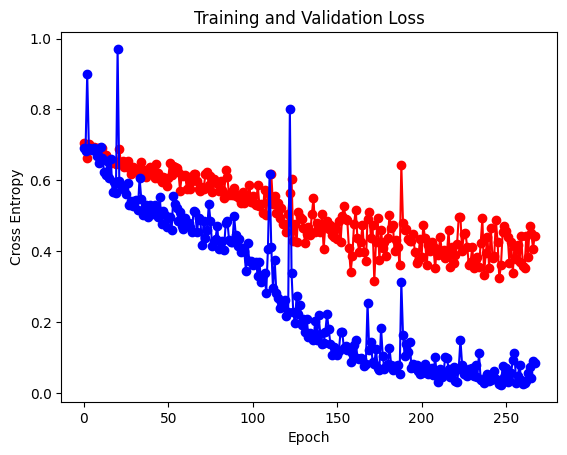

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

## Model evaluation

## Save the Model

In [17]:
model.save('./model/inception_model_2.h5')